# Solving portfolio optimization as QUBO problem with QAOA

## Overview

In this tutorial we will demonstrate how to solve quadratic unconstrained binary optimization (QUBO) problems using QAOA.

## QUBO problem

### what is QUBO?

Quadratic unconstrained binary optimization (QUBO) is a type of problem that aims to optimize a quadratic objective function using binary variables. The primary goal of a QUBO problem is to determine the assignments of binary variables that minimize or maximize the quadratic objective function. These variables represent choices or decision variables that can be either selected (1) or not selected (0). The objective function captures the associated costs, benefits, or constraints related to these decisions.

From a computational perspective, solving a QUBO problem is generally considered NP-hard. This classification implies that finding the optimal solution to a QUBO instance is believed to be computationally challenging, and there is no known polynomial-time algorithm that can efficiently solve all QUBO problems.

However, a promising approach called Quantum Approximate Optimization Algorithm (QAOA), introduced in this [this tutorial](https://tensorcircuit.readthedocs.io/en/latest/tutorials/qaoa.html), has the potential to offer significant advantages when applied to QUBO problem solving. QAOA leverages the inherent quantum parallelism and interference effects to explore the solution space more efficiently compared to classical methods. This efficiency can lead to faster and more optimal solutions. In QAOA, each qubit represents a binary variable, and the objective function is calculated as the expected value of a quantum state generated by the ansatz. The parameters in the ansatz are iteratively optimized by a classical algorithm to improve the solution quality.

### General Case

For the general QUBO case, we wish to minimize the cost function in the form of

$$ x^T Q x$$

where $x\in\{0,1\}^n$ and $Q\in\mathbb{R}^{n\times n}$ is a real symmetric matrix.

This function maps to an Ising Hamiltonian 

$$\frac{1}{2}\left(\sum_{i=1}^n C_{ii} + \sum_{i<j}C_{ij}\right) I - \frac{1}{2}\sum_{i=1}^n \left(\sum_{j=1}^n C_{ij} \right)Z_i +\frac{1}{2}\sum_{i<j}C_{ij}Z_iZ_j$$

This Hamiltonian is then represented with quantum gates and then put in the cost terms of the ansatz. At the same time, the cost function is defined as the expected value of this Ising Hamiltonian.

### An example

Consider minimizing the following 2x2 QUBO objective function:

$$\begin{pmatrix}x_1 & x_2\end{pmatrix}\begin{pmatrix}-5& -2 \\-2 & 6\end{pmatrix}\begin{pmatrix}x_1\\x_2\end{pmatrix} = -5x_1^2 -4x_1x_2 +6x_2^2$$

Clearly this cost fucntion is minimized when $(x_1,x_2) = (1,0)$, with corresponding cost value of $-5$. Then we are going to apple QAOA on this minimization. We first convert this to an Ising Hamiltonian by mapping $x_i\rightarrow \frac{I-Z_i}{2}$

This gives

$$-\frac{5}{4}(I-Z_1)^2 -\frac{4}{4}(I-Z_1)(I-Z_2) + \frac{6}{4}(I-Z_2)^2 $$

which simplifies to

$$-\frac{1}{2}I +\frac{7}{2}Z_1   -2Z_2 -Z_1Z_2$$ 

The $-I/2$ term is simply a constant offset, so we can solve the problem by finding the minimum of 

$$\langle \psi | \frac{7}{2}Z_1 -2Z_2 -Z_1Z_2 |\psi\rangle$$ 

Note that the minimum should correspond to the computational basis state $|10\rangle$, and the corresponding true objective function value should be $-4.5$ (ignoring the offset value of $-1/2$). Below, the code of solving QUBO problem is shown.

## Setup

In [11]:
## ready to delete
from typing import List, Tuple, Callable

## ready to modify
from ....tensorcircuit.templates.blocks import QAOA_ansatz_for_Ising


ImportError: attempted relative import with no known parent package

In [ ]:
import tensorcircuit as tc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from functools import partial
import time

K = tc.set_backend("tensorflow")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Define a function to convert the Q-matrix to Ising Hamiltonian

In [ ]:
def QUBO_to_Ising(Q: List[list]) -> Tuple[List[list], list, float]:
    """
    Cnvert the Q matrix into a the indication of pauli terms, the corresponding weights, and the offset.
    The outputs are used to construct an Ising Hamiltonian for QAOA.

    :param Q: The n-by-n square and symmetric Q-matrix.
    :return pauli_terms: A list of 0/1 series, where each element represents a Pauli term.
    A value of 1 indicates the presence of a Pauli-Z operator, while a value of 0 indicates its absence.
    :return weights: A list of weights corresponding to each Pauli term.
    :return offset: A float representing the offset term of the Ising Hamiltonian.
    """

    # input is n-by-n symmetric numpy array corresponding to Q-matrix
    # output is the components of Ising Hamiltonian

    n = Q.shape[0]

    # square matrix check
    if Q[0].shape[0] != n:
        raise ValueError("Matrix is not a square matrix.")

    offset = (
        np.triu(Q, 0).sum() / 2
    )  # Calculate the offset term of the Ising Hamiltonian
    pauli_terms = []  # List to store the Pauli terms
    weights = (
        -np.sum(Q, axis=1) / 2
    )  # Calculate the weights corresponding to each Pauli term

    for i in range(n):
        term = np.zeros(n)
        term[i] = 1
        pauli_terms.append(
            term.tolist()
        )  # Add a Pauli term corresponding to a single qubit

    for i in range(n - 1):
        for j in range(i + 1, n):
            term = np.zeros(n)
            term[i] = 1
            term[j] = 1
            pauli_terms.append(
                term.tolist()
            )  # Add a Pauli term corresponding to a two-qubit interaction

            weight = (
                Q[i][j] / 2
            )  # Calculate the weight for the two-qubit interaction term
            weights = np.concatenate(
                (weights, weight), axis=None
            )  # Add the weight to the weights list

    return pauli_terms, weights, offset

Let's test this function with our example. The result is exactly the same as what we derived.

In [ ]:
# Example usage
Q = np.array([[-5, -2], [-2, 6]])  # Example Q-matrix
pauli_terms, weights, offset = QUBO_to_Ising(Q)
print("The Pauli terms in this QUBO problem are:", pauli_terms)
print("And the corresponding weights are:", weights)
print("The offset is:", offset)

The Pauli terms in this QUBO problem are: [[1.0, 0.0], [0.0, 1.0], [1.0, 1.0]]
And the corresponding weights are: [ 3.5 -2.  -1. ]
The offset is: -0.5


Define the QAOA ansatz. As mentioned in the [QAOA tutorial](https://tensorcircuit.readthedocs.io/en/latest/tutorials/qaoa.html), the ansatz consists of two parts: cost terms and mixer terms. 

Define the cost function as the expection value of the Ising Hamiltonian.

In [ ]:
def Ising_loss(c: tc.Circuit, pauli_terms: List[list], weights: list) -> float:
    """
    computes the loss function for the Ising model based on a given quantum circuit,
    a list of Pauli terms, and corresponding weights.
    The offset is ignored.

    :param c: A quantum circuit object generating the state.
    :param pauli_terms: A list of Pauli terms, where each term is represented as a list of 0/1 series.
    :param weights: A list of weights corresponding to each Pauli term.
    :return loss: A real number representing the computed loss value.
    """
    loss = 0.0
    for k in range(len(pauli_terms)):
        term = pauli_terms[k]
        index_of_ones = []

        for l in range(len(term)):
            if term[l] == 1:
                index_of_ones.append(l)

        # Compute expectation value based on the number of qubits involved in the Pauli term
        if len(index_of_ones) == 1:
            delta_loss = weights[k] * c.expectation_ps(z=[index_of_ones[0]])
            # Compute expectation value for a single-qubit Pauli term
        else:
            delta_loss = weights[k] * c.expectation_ps(
                z=[index_of_ones[0], index_of_ones[1]]
            )
            # Compute expectation value for a two-qubit Pauli term

        loss += delta_loss

    return K.real(loss)

For the particular case of a circuit corresponding to a QAOA ansatz this is:

In [ ]:
def QAOA_loss(
    nlayers: int, pauli_terms: List[list], weights: list, params: list
) -> float:
    """
    computes the loss function for the Quantum Approximate Optimization Algorithm (QAOA) applied to the Ising model.
    
    :param nlayers: The number of layers in the QAOA ansatz.
    :param pauli_terms: A list of Pauli terms, where each term is represented as a list of 0/1 series.
    :param weights: A list of weights corresponding to each Pauli term.
    :param params: A list of parameter values used in the QAOA ansatz.
    :return: The computed loss value.
    """
    c = QAOA_ansatz_for_Ising(params, nlayers, pauli_terms, weights)
    # Obtain the quantum circuit using QAOA_from_Ising function

    return Ising_loss(c, pauli_terms, weights)
    # Compute the Ising loss using Ising_loss function on the obtained circuit

Then we combine all functions we defined and get a solver of QUBO problems.

In [ ]:
def QUBO_QAOA(
    Q: List[list],
    ansatz: Callable[[list, int, List[list], list], tc.Circuit],
    nlayers: int,
    iterations: int,
    vvag: bool = False,
    ncircuits: int = 10,
) -> list:
    """
    Performs the QAOA on a given QUBO problem.

    :param Q: The n-by-n square and symmetric Q-matrix representing the QUBO problem.
    :param ansatz: The ansatz function to be used for the QAOA.
    :param nlayers: The number of layers in the QAOA ansatz.
    :param iterations: The number of iterations to run the optimization.
    :param vvag (optional): A flag indicating whether to use vectorized variational adjoint gradient. Default is False.
    :param ncircuits (optional): The number of circuits when using vectorized variational adjoint gradient. Default is 10.
    :return params: The optimized parameters for the ansatz circuit.
    """
    try:
        K
    except NameError:
        print('select a backend and assign it to K.')
        
    pauli_terms, weights, offset = QUBO_to_Ising(Q)
    learning_rate = 1e-2

    loss_val_grad = K.value_and_grad(partial(ansatz, nlayers, pauli_terms, weights))
    params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)
    # Initialize the parameters for the ansatz circuit

    if vvag == True:
        loss_val_grad = tc.backend.vvag(loss_val_grad, argnums=0, vectorized_argnums=0)
        params = K.implicit_randn(shape=[ncircuits, 2 * nlayers], stddev=0.1)
        # Use vectorized variational adjoint gradient (vvag) if vvag flag is set to True

    loss_val_grad_jit = K.jit(loss_val_grad, static_argnums=(1, 2))

    opt = K.optimizer(tf.keras.optimizers.Adam(learning_rate))
    # Define the optimizer (Adam optimizer) with the specified learning rate

    for i in range(iterations):
        loss, grads = loss_val_grad_jit(params)
        # Calculate the loss and gradients using the loss_val_grad_jit function

        params = opt.update(grads, params)
        # Update the parameters using the optimizer and gradients

        if i % 100 == 0:  # print the cost every 100 iterations
            print(K.numpy(loss))

    return params

define functions to list the results

In [ ]:
def print_result_prob(c: tc.Circuit, wrap: bool = False, reverse: bool = False) -> None:
    """
    Print the results and probabilities of a given quantum circuit.
    The default order is from the highest probability to the lowest one

    :param c: The quantum circuit to print the results and probabilities.
    :param wrap (optional): A flag indicating whether to wrap the output. Default is False.
    :param reverse (optional): A flag indicating whether to reverse the order of the output. Default is False.
    """
    try:
        K
    except NameError:
        print('select a backend and assign it to K.')

    states = []
    n_qubits = c._nqubits
    for i in range(2**n_qubits):
        a = f"{bin(i)[2:]:0>{n_qubits}}"
        states.append(a)
        # Generate all possible binary states for the given number of qubits

    probs = K.numpy(c.probability()).round(decimals=4)
    # Calculate the probabilities of each state using the circuit's probability method

    sorted_indices = np.argsort(probs)[::-1]
    if reverse == True:
        sorted_indices = sorted_indices[::-1]
    state_sorted = np.array(states)[sorted_indices]
    prob_sorted = np.array(probs)[sorted_indices]
    # Sort the states and probabilities in descending order based on the probabilities

    print("\n-------------------------------------")
    print("    selection\t  |\tprobability")
    print("-------------------------------------")
    if wrap == False:
        for i in range(len(states)):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
            # Print the sorted states and their corresponding probabilities
    elif wrap == True:
        for i in range(4):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
        print("               ... ...")
        for i in range(-4, -1):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
    print("-------------------------------------")


def print_result_cost(c: tc.Circuit, Q: List[list], wrap: bool = False, reverse: bool = False) -> None:
    """
    Print the results and costs of a given quantum circuit.
    Specificly designed for the variational circuit.
    """
    cost_dict = {}
    states = []
    n_qubits = c._nqubits
    for i in range(2**n_qubits):
        a = f"{bin(i)[2:]:0>{n_qubits}}"
        states.append(a)
        # Generate all possible binary states for the given number of qubits
    for selection in states:
        x = np.array([int(bit) for bit in selection])
        cost_dict[selection] = np.dot(x, np.dot(Q, x))
    if reverse == False:
        cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
    elif reverse == True:
        cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1], reverse=True))
    num = 0
    print("\n-------------------------------------")
    print("    selection\t  |\t  cost")
    print("-------------------------------------")
    for k, v in cost_sorted.items():
        print("%10s\t  |\t%.4f" % (k, v))
        num += 1
        if (num >= 8) & (wrap == True):
            pass
    print("-------------------------------------")

In [ ]:
abc = 1
try:
    abc
except NameError:
    print('select a backend and assign it to K.')

## Results

Train the quantum circuit for 500 iterations.

In [ ]:
iterations = 500
nlayers = 2

time_start = time.time()  # Record the starting time

final_params = QUBO_QAOA(Q, QAOA_loss, nlayers, iterations)
# Run QUBO_QAOA function to obtain the final parameters

time_end = time.time()  # Record the ending time

print("time consumed:", round(time_end - time_start, 4), "s")
# Print the time consumed for the QUBO-QAOA optimization process

1.6567761
-3.2792811
-3.8205552
-3.9764287
-4.2347913
time consumed: 1.9002 s


Note that with 2 layers and 500 iterations, the objective function does not in this case (although it depends on the initial parameters) converge to the true value of $-4.5$. However, the we see below that the final wavefunction does have significant overlap with the desired state $|10\rangle$, and then the output of the QAOA algorithm will, with high probability, give the best combiantion.

Define a function a print a table of results, where all quantum states are listed in the order of possibilities.

In [ ]:
c = QAOA_ansatz_for_Ising(final_params, nlayers, pauli_terms, weights)

print_result_prob(c)
print_result_cost(c, Q)


-------------------------------------
    selection	  |	probability
-------------------------------------
        10	  |	  0.9943
        11	  |	  0.0029
        00	  |	  0.0015
        01	  |	  0.0014
-------------------------------------


TypeError: unhashable type: 'slice'

In [ ]:
import matplotlib.pyplot as plt

def print_output(c):
    n = c._nqubits
    N = 2**n
    # Calculate the total number of states based on the number of qubits

    x_label = r"$\left|{0:0" + str(n) + r"b}\right>$"
    labels = [x_label.format(i) for i in range(N)]
    # Generate labels for the x-axis representing the binary states

    plt.bar(range(N), c.probability())
    # Create a bar plot with the probabilities of each state

    plt.xticks(range(N), labels, rotation=70)
    # Set the x-axis ticks to the generated labels and rotate them for better visibility

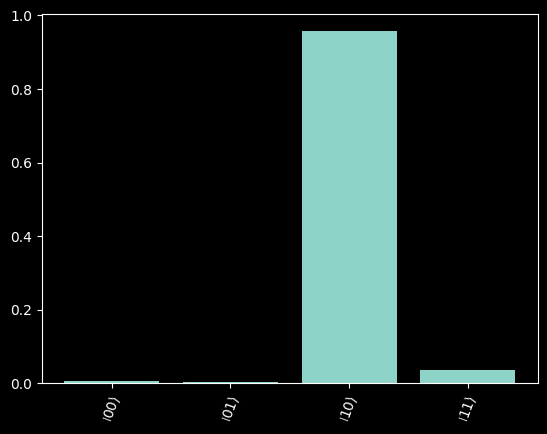

In [ ]:
print_output(c)